In [11]:
using CollectiveSpins
using PyPlot
using Statistics
using JLD2
using ProgressMeter
using QuantumOptics
using OrdinaryDiffEq
using Libdl

In [12]:
""" Prepare the initial state of the system 
with a phase correlation imposed between the atoms
because the laser arrive on the lattice with an angle θl """
function prepare_phi_IS(θl, λl, theta_array)
    phi_array = zeros(N)
    for i = 1:N
        phi_array[i] = 2pi * sqrt(sum((system.spins[i].position .* [cos(θl), sin(θl), 0]) .^ 2))
    end
    return phi_array
end

""" Prepare the initial vector u0 """
function u0_CFunction(phi_array, theta_array, op_list)
    u0 = ones(ComplexF64, length(op_list))
    for i in 1:length(op_list)
        if length(op_list[i]) == 1
            j = Int(op_list[i][1] % 10^floor(log10(abs(op_list[i][1]))-1)) # Atom nbr
            if parse(Int, string(op_list[i][1])[1:2]) == 22
                u0[i] = cos(theta_array[j]/2)^2
            elseif parse(Int, string(op_list[i][1])[1:2]) == 21
                u0[i] = cos(theta_array[j]/2)*exp(1im*phi_array[j])*sin(theta_array[j]/2)
            else
                println(op_list[i][1])
            end
        end

        if length(op_list[i]) == 2
            for op in op_list[i]
                j = Int(op % 10^floor(log10(abs(op))-1)) # Atom nbr
                if parse(Int, string(op)[1:2]) == 22
                    u0[i] *= cos(theta_array[j]/2)^2
                elseif parse(Int, string(op)[1:2]) == 21
                    u0[i] *= cos(theta_array[j]/2)*exp(1im*phi_array[j])*sin(theta_array[j]/2)
                elseif parse(Int, string(op)[1:2]) == 12
                    u0[i] *= cos(theta_array[j]/2)*exp(-1im*phi_array[j])*sin(theta_array[j]/2)
                else
                    println(op)
                end
            end
        end
    end
    return u0
end

""" Function loading the block subfunction when a lot of equations are involved """
function load_f(fname::String, libpath::String)
	lib = Libdl.dlopen(libpath)
	fptr = Libdl.dlsym(lib, fname)
	return (du, u) -> ccall(fptr, Cvoid, (Ptr{ComplexF64}, Ptr{ComplexF64}), du, u)
end

load_f

### Define the system

In [13]:
# Define geometry of system
Nx,Ny,Nz = [5,5,1]
N = Nx*Ny*Nz
d_xy, d_z = 266., 532. # Optical lattice spacing in nm
e = [0,0,1]   # Quantization axis

# Initial values
theta_init = 0
phi_init = 0 # 1 if laser induced correlations between the atoms, 0 else

λ = 1299.
θl = 30*pi/180 # Angle of the laser

a,b,c = [d_xy,d_xy,d_z]/λ
geo = geometry.box(a,b,c;Nx=Nx,Ny=Ny,Nz=Nz)
system = SpinCollection(geo, e, gammas=1.)

repetitions = 10

Tstep, Tend = 1e-3, 1 # Normalised by Γ0
T = [0:Tstep:Tend;];

In [14]:
# Load the operators
var_filling_fraction = 2/N; r = 1
@load "Operators/op_list_FF_$(round(var_filling_fraction, digits=2))_rep_$r.jdl2" op_list
theta_array = ones(N)*theta_init
phi_array = prepare_phi_IS(θl, λ, theta_array)*phi_init;

In [15]:
# Prepare the wrapper
const N_FUNCS = length(readdir("libs"))  # Total function nbr
const functions = Vector{Function}(undef, N_FUNCS)
func_count = 1
for i = 2:2:N
    var_filling_fraction = i/N
    for r in 1:repetitions
        libpath ="libs/liballfuncs_FF_$(round(var_filling_fraction, digits=2))_rep_$r.dll"
        functions[func_count] = load_f("diffeqf", libpath)
        func_count += 1
    end
end

# Max slope

In [16]:
var_FF_max_diff_mean_σz = []
std_var_FF_max_diff_mean_σz = []
sols = []

func_count = 1

@showprogress for i = 2:2:N
    var_filling_fraction = i/N
    max_diff_σz_rep = []

    for r in 1:repetitions
        # Load the functions
        fsolve(du, u, p, t) = functions[func_count](du, u)

        # Find the mean values that should be set to 0 (no atoms)
        u0 = u0_CFunction(phi_array, theta_array, op_list);
        A, B = ones(ComplexF64, length(u0)), ones(ComplexF64, length(u0))
        fsolve(B, A, 0, 0)
        u0[findall(x -> x == 0, B)] .= 0
        
        # Solve the problem
        prob = OrdinaryDiffEq.ODEProblem(fsolve, u0, (T[1], T[end]))
        sol = OrdinaryDiffEq.solve(prob, OrdinaryDiffEq.DP5(), saveat=T;
                reltol=1.0e-6,
                abstol=1.0e-8).u;
        
        mean_σz_QC = [2*sum(real(sol[t][1:N]))./i-1 for t=1:length(T)]
        mean_σz67_QC = -1 .*(mean_σz_QC.+1) ./2 .- 6
        push!(sols, mean_σz67_QC)
        push!(max_diff_σz_rep, maximum(diff(mean_σz67_QC)./Tstep))
        func_count += 1

        # Free variable name
        fsolve = nothing
    end
    push!(var_FF_max_diff_mean_σz, mean(max_diff_σz_rep)[1])
    push!(std_var_FF_max_diff_mean_σz, std(max_diff_σz_rep)[1])
end

Progress: 100%|█████████████████████████████████████████| Time: 0:08:25


In [17]:
@save "VarFF_MaxSlope_QC_Nx_$(Nx)_Ny_$(Ny)_Nz_$(Nz)_theta_$(round(theta_init, digits=1))_phi_$(phi_init)_thetal_$(round(θl, digits=2)).jld2" var_FF_max_diff_mean_σz std_var_FF_max_diff_mean_σz sols

In [18]:
@load "VarFF_MaxSlope_QC_Nx_$(Nx)_Ny_$(Ny)_Nz_$(Nz)_theta_$(round(theta_init, digits=1))_phi_$(phi_init)_thetal_$(round(θl, digits=2)).jld2" var_FF_max_diff_mean_σz std_var_FF_max_diff_mean_σz sols;

# Plots

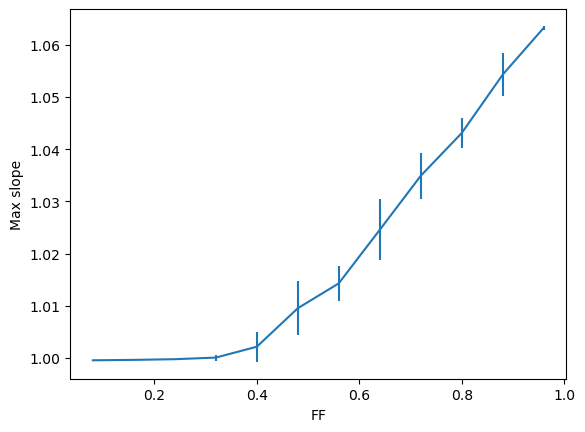

In [ ]:
close("all")

errorbar([i for i=2:2:N]./N, var_FF_max_diff_mean_σz, yerr=std_var_FF_max_diff_mean_σz)

xlabel("FF")
ylabel("Max slope")

pygui(false); gcf()
#pygui(true); show()

# Plot solutions

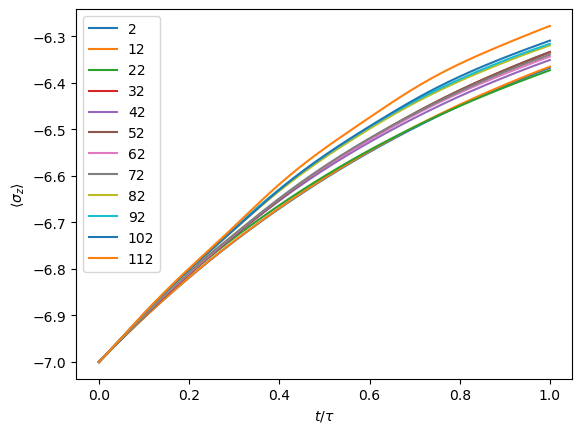

In [20]:
close("all")
figure()

nbr_at = 1
for i = 2:10:N_FUNCS
    plot(T, sols[i], label=string(i))
    nbr_at += 1
end

legend()
xlabel(L"t/\tau")
ylabel(L"\langle\sigma_z\rangle")

pygui(false); gcf()